In [1]:
from pathlib import Path

In [2]:
from utils.wsi.patches import generate_patches


     - Powered by -     
   _______   __________   
  / __/ _ | / __/_  __/   https://fast.eriksmistad.no
 / _// __ |_\ \  / /               v4.4.0
/_/ /_/ |_/___/ /_/       



In [3]:
generate_patches?

Signature:
generate_patches(
    source_file: pathlib.Path,
    dest_dir: pathlib.Path,
    pyramid: int = 0,
    size: Tuple[int, int] = (512, 512),
    threshold: float = 50.0,
    overlap: int = 0,
    depth: int = 2,
    seg_patches: bool = True,
) -> pathlib.Path
Docstring: Generate Training patches from svs files
File:      ~/source/dl/lihc/utils/wsi/patches.py
Type:      function


In [4]:
wsi, seg = generate_patches(
    Path("data/wsi/Training_phase_1_001/01_01_0083.svs"),
    Path("data/train"),
    size=(256, 256),
    seg_patches=True
)

Generating tiles...
Generating training patches...
Generating segmentation patches


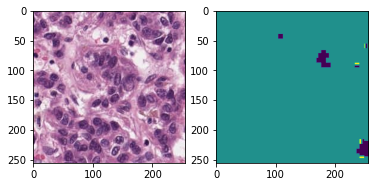

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

patches = wsi.glob("*.jpeg")

patch_path = next(patches)
patch = Image.open(patch_path)
seg_img = Image.open(Path(seg, patch_path.name))
    
fig, ax = plt.subplots(1, 2)
ax[0].imshow(patch)
ax[1].imshow(seg_img)

plt.show()

In [6]:
import torch
import torch.utils.data as data
import torchvision.io as io

class WSIDataset(data.Dataset):
    def __init__(self, wsi: Path, seg: Path):
        self.wsi = wsi
        self.seg = seg
        self.patches = sorted(list(wsi.glob("*.jpeg")))
        
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch = io.read_image(str(self.patches[idx]), io.ImageReadMode.UNCHANGED)
        seg = io.read_image(str(Path(self.seg, self.patches[idx].name)), io.ImageReadMode.UNCHANGED)
        return patch.type(torch.FloatTensor) , seg.type(torch.FloatTensor)
        

In [7]:
dataset = WSIDataset(wsi, seg)
train_data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [8]:
dataset[0][1].shape

torch.Size([1, 256, 256])

In [9]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="mobilenet_v2", 
    activation='sigmoid',
    in_channels=3,                  
    classes=1,                      
)

In [10]:
import torch.optim as optim

optimiser = optim.Adam(model.parameters())
loss = smp.losses.DiceLoss("binary")

In [11]:
epochs = 1
batch_loss = 0

for epoch in range(epochs):
    print(f"Epoch: {epoch}") 
    for i, data in enumerate(train_data_loader):
        patch, s = data
        optimiser.zero_grad()
        outputs = model(patch)
        ls = loss(outputs, s)
        batch_loss += ls.item()
        if i % 10 == 9:
            print(f"loss: {batch_loss / 10}")
            batch_loss = 0
        ls.backward()
        optimiser.step()

Epoch: 0
loss: 0.3792821645736694
loss: 0.3558399200439453
loss: 0.4014540553092957
loss: 0.34106866717338563
loss: 0.4008489966392517
loss: 0.42785950303077697
loss: 0.39079710841178894
loss: 0.3440843284130096
loss: 0.2945145845413208
loss: 0.406933057308197
loss: 0.34420467615127565
loss: 0.3379661560058594
loss: 0.3806219756603241
loss: 0.3055638253688812
loss: 0.3943967819213867
loss: 0.36043988466262816
loss: 0.297593754529953
loss: 0.34074264764785767
loss: 0.35705365538597106
loss: 0.32310585379600526
loss: 0.3265726029872894
loss: 0.35387682914733887
loss: 0.36154489517211913
loss: 0.39025951623916627
loss: 0.3627868711948395
loss: 0.366362988948822
loss: 0.33892509937286375
loss: 0.36950517892837526
loss: 0.3516272962093353
loss: 0.41803509593009947
loss: 0.3540445864200592
loss: 0.3811032593250275
loss: 0.305917227268219
loss: 0.343254828453064
loss: 0.4203397691249847
loss: 0.3060732901096344
loss: 0.3703920304775238
loss: 0.30259904861450193
loss: 0.32735602259635926
loss:

KeyboardInterrupt: 